# <a id='toc1_'></a>[Data Cleaning](#toc0_)

This notebook describes the data collection and cleaning process for a steam game recommenation system.  The recommendation system should predict a user's preferences (or a similarity score) for  games found on Steam.  For this reason, datasets that provided information about the games, user recommenations, and user ratings were considered.

**Table of contents**<a id='toc0_'></a>    
- [Data Cleaning](#toc1_)    
  - [Data Collection](#toc1_1_)    
  - [Data Cleaning](#toc1_2_)    
  - [Data Output and Data Dictionaries](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Data Collection](#toc0_)

Existing datasets were used from Kaggle that contained information about games found on Steam along with user review scores and user recommenations.

The following datasets will be used in this project:

- Game Recommenations on Steam by Anton Kozyriev: <a href="https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam/code?select=games.csv" target="_blank">link</a>
    - includes: 
        - games.csv
        - recommenations.csv
        - users.csv
        - games_metadata.json

## <a id='toc1_2_'></a>[Data Cleaning](#toc0_)

In [1]:
# import  holy tinity of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# to join my json files to my dataframes
import json

# to collect missing steam info
from scraping_tools import get_app_pubs_devs
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading in the "raw" data
game_reviews_df = pd.read_csv('data/games.csv')
recommendations_df = pd.read_csv('data/recommendations.csv')
users_df = pd.read_csv('data/users.csv')
steam_games_df = pd.read_csv('data/steam_games.csv', sep=';') # note, this file is semicolon delimited

In [4]:
print('There are', recommendations_df['user_id'].nunique(), 'unique users')
print(f'There are {len(recommendations_df)} total reviews')

There are 6903784 unique users
There are 14585291 total reviews


In [5]:
game_titles = game_reviews_df[['app_id', 'title']]
game_titles.to_csv('data/game_titles.csv', index=False)

For each of these data sets, I want to remove unwanted duplicates and null values wherever possible.

### 1. game_reviews_df Cleaning

In [3]:
game_reviews_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True


In [4]:
game_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48844 entries, 0 to 48843
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          48844 non-null  int64  
 1   title           48844 non-null  object 
 2   date_release    48844 non-null  object 
 3   win             48844 non-null  bool   
 4   mac             48844 non-null  bool   
 5   linux           48844 non-null  bool   
 6   rating          48844 non-null  object 
 7   positive_ratio  48844 non-null  int64  
 8   user_reviews    48844 non-null  int64  
 9   price_final     48844 non-null  float64
 10  price_original  48844 non-null  float64
 11  discount        48844 non-null  float64
 12  steam_deck      48844 non-null  bool   
dtypes: bool(4), float64(3), int64(3), object(3)
memory usage: 3.5+ MB


In [5]:
# check for duplicated rows and columns
print(f'Number of duplicated rows: {game_reviews_df.duplicated().sum()}')
print(f'Number of duplicated columns: {game_reviews_df.duplicated().T.sum()}')

Number of duplicated rows: 0
Number of duplicated columns: 0


In [6]:
# convert 'date_release' to a datetime
game_reviews_df['date_release'] = pd.to_datetime(game_reviews_df['date_release'])

In [7]:
# convert bool columns to int
bool_cols = ['win', 'mac', 'linux', 'steam_deck']

for col in bool_cols:
    game_reviews_df[col] = np.where(game_reviews_df[col], 1, 0)

In [8]:
# confirm this worked
game_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48844 entries, 0 to 48843
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_id          48844 non-null  int64         
 1   title           48844 non-null  object        
 2   date_release    48844 non-null  datetime64[ns]
 3   win             48844 non-null  int32         
 4   mac             48844 non-null  int32         
 5   linux           48844 non-null  int32         
 6   rating          48844 non-null  object        
 7   positive_ratio  48844 non-null  int64         
 8   user_reviews    48844 non-null  int64         
 9   price_final     48844 non-null  float64       
 10  price_original  48844 non-null  float64       
 11  discount        48844 non-null  float64       
 12  steam_deck      48844 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(4), int64(3), object(2)
memory usage: 4.1+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48844 entries, 0 to 48843
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   win         48844 non-null  int32
 1   mac         48844 non-null  int32
 2   linux       48844 non-null  int32
 3   steam_deck  48844 non-null  int32
dtypes: int32(4)
memory usage: 763.3 KB


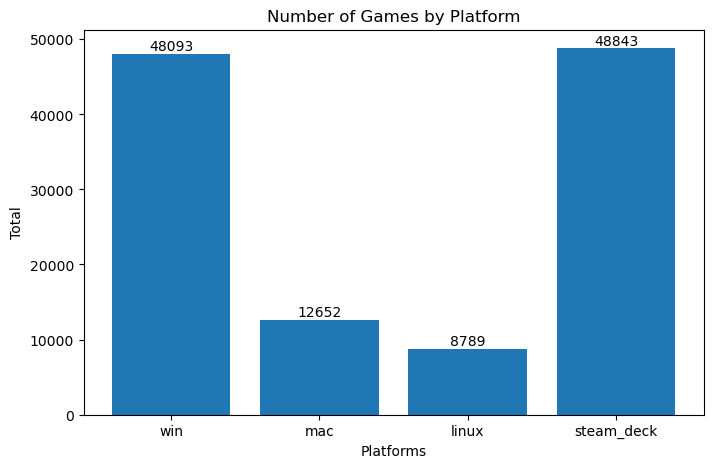

In [9]:
# see platform information
platforms = game_reviews_df[['win','mac','linux','steam_deck']]
platforms.info()

plt.figure(figsize=(8,5))

# sum each column
totals = platforms.sum()

plt.bar(totals.index, totals.values)
plt.xlabel('Platforms')
plt.ylabel('Total')
plt.title('Number of Games by Platform')

for i, v in enumerate(totals):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

This tells us that, of the 48,844 data points we have, all but one is compatible with steam deck.  This seems incorrect given the fact that Steam Deck is a relatively new platform.  We know, for instance, that the Dragon Age games are not compatible with Steam Deck (at the time of writing this).  Let's check to see how they are classified:

In [10]:
game_reviews_df.loc[game_reviews_df['title'].str.contains(r'Dragon Age', case=False, regex=True), ['title','steam_deck']]

,title,steam_deck
555,Dragon Age™ Inquisition,1
2408,Dragon Age II: Ultimate Edition,1
15596,Dragon Age II DLC Bundle,1
17949,Dragon Age: Origins - Ultimate Edition,1


Since they are being classified as compatible, but we know that they are not, we now know the data collection process did not return accurate results.  So, since the data is inaccurate, and since a column in which all but one value is '1' will not provide meaningful information, I will drop this column entirely. 

In [11]:
game_reviews_df.drop(columns='steam_deck', inplace=True)

Next, let's look at the `rating` column.

In [12]:
game_reviews_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount
0,10090,Call of Duty: World at War,2008-11-18,1,0,0,Very Positive,92,37039,19.99,19.99,0.0
1,13500,Prince of Persia: Warrior Within™,2008-11-21,1,0,0,Very Positive,84,2199,9.99,9.99,0.0
2,22364,BRINK: Agents of Change,2011-08-03,1,0,0,Positive,85,21,2.99,2.99,0.0
3,113020,Monaco: What's Yours Is Mine,2013-04-24,1,1,1,Very Positive,92,3722,14.99,14.99,0.0
4,226560,Escape Dead Island,2014-11-18,1,0,0,Mixed,61,873,14.99,14.99,0.0


In [13]:
game_reviews_df['rating'].value_counts()

Very Positive              12755
Positive                   12577
Mixed                      11822
Mostly Positive             8463
Mostly Negative             1797
Overwhelmingly Positive     1071
Negative                     290
Very Negative                 56
Overwhelmingly Negative       13
Name: rating, dtype: int64

In [14]:
recommendations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14585291 entries, 0 to 14585290
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 792.8+ MB


The `game_reviews_df['rating']` has more fine-grained distinctions than merely "positive" and "negative" ratings.  However, since the `recommendations_df['is_recommended']` value is boolean, I will convert these to be aligned with that column. 

In [15]:
# map everything worse than 'positive' to '0', otherwise '1'
game_reviews_df['rating'] = game_reviews_df['rating'].map({
    'Overwhelmingly Positive': 1,
    'Very Positive': 1,
    'Positive': 1,
    'Mostly Positive': 0,
    'Mixed': 0,
    'Mostly Negative': 0,
    'Negative': 0,
    'Very Negative': 0,
    'Overwhelmingly Negative': 0
})

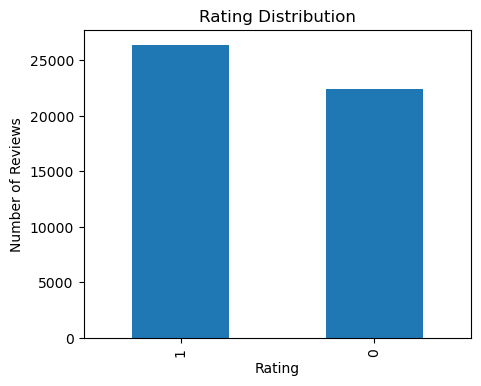

In [16]:
# check to see distribution
plt.figure(figsize=(5,4))

game_reviews_df['rating'].value_counts().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

plt.show()

In [17]:
game_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48844 entries, 0 to 48843
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_id          48844 non-null  int64         
 1   title           48844 non-null  object        
 2   date_release    48844 non-null  datetime64[ns]
 3   win             48844 non-null  int32         
 4   mac             48844 non-null  int32         
 5   linux           48844 non-null  int32         
 6   rating          48844 non-null  int64         
 7   positive_ratio  48844 non-null  int64         
 8   user_reviews    48844 non-null  int64         
 9   price_final     48844 non-null  float64       
 10  price_original  48844 non-null  float64       
 11  discount        48844 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(3), int64(4), object(1)
memory usage: 3.9+ MB


I now want to add in game descriptions and tags to each app_id from the `games_metadata.json` file.  Tags will be one-hot encoded while descriptions will (for now) be contained in a single column.

In [18]:
# list to store parsed json objects
metadata_list = []

# Read the JSON file line by line
with open('data/games_metadata.json', 'r') as file:
    for line in file:
        # Parse each line as a JSON object
        data = json.loads(line)

        # Append the JSON object to the metadata_list
        metadata_list.append(data)

In [19]:
# Create lists to store the description and tags
descriptions = []
tags_list = []

for data in metadata_list:
    app_id = data['app_id']
    description = data.get('description', '')  # If no description, use an empty string
    tags = data.get('tags', [])  # If no tags, use an empty list

    descriptions.append(description)
    tags_list.append(tags)

# Merge the description and tags with game_reviews_df
game_reviews_df['description'] = descriptions
game_reviews_df['tags'] = tags_list

In [20]:
# check to ensure these columns have been successfully added
game_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48844 entries, 0 to 48843
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_id          48844 non-null  int64         
 1   title           48844 non-null  object        
 2   date_release    48844 non-null  datetime64[ns]
 3   win             48844 non-null  int32         
 4   mac             48844 non-null  int32         
 5   linux           48844 non-null  int32         
 6   rating          48844 non-null  int64         
 7   positive_ratio  48844 non-null  int64         
 8   user_reviews    48844 non-null  int64         
 9   price_final     48844 non-null  float64       
 10  price_original  48844 non-null  float64       
 11  discount        48844 non-null  float64       
 12  description     48844 non-null  object        
 13  tags            48844 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(3), int64(4), 

In [21]:
game_reviews_df[['description', 'tags']].head()

,description,tags
0,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti..."
1,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
2,,[Action]
3,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."


In [22]:
# one-hot encode tags
tags_df = pd.get_dummies(game_reviews_df['tags'].apply(pd.Series).stack()).sum(level=0)

In [23]:
# rename columns to include t_
tags_df = tags_df.rename(columns=lambda x: 't_' + x)

In [24]:
print(f'Number of unique tags: {len(tags_df.columns)}')

Number of unique tags: 441


In [25]:
# add the one-hot encoded tags to the df
game_reviews_df = pd.concat([game_reviews_df, tags_df], axis=1)

In [26]:
game_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48844 entries, 0 to 48843
Columns: 455 entries, app_id to t_eSports
dtypes: datetime64[ns](1), float64(444), int32(3), int64(4), object(3)
memory usage: 169.0+ MB


In [27]:
# now that we have the one-hot encoded tags, we don't need the tags column
game_reviews_df.drop(columns='tags', inplace=True)

This dataset is in a good place.  The only two columns that are not numerical are now description and name.  This is fine for now.  If my modelling requires these columns, I will make adjustments then.

### 2. recommendations_df Cleaning

In [28]:
recommendations_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,24170,0
1,304390,4,0,2017-02-17,False,11.5,1339,1
2,1085660,2,0,2019-11-17,True,336.5,110271,2
3,703080,0,0,2022-09-23,True,27.4,112510,3
4,526870,0,0,2021-01-10,True,7.9,11046,4


In [29]:
recommendations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14585291 entries, 0 to 14585290
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 792.8+ MB


In [30]:
# check for duplicated rows and columns
print(f'Number of duplicated rows: {recommendations_df.duplicated().sum()}')
print(f'Number of duplicated columns: {recommendations_df.duplicated().T.sum()}')

Number of duplicated rows: 0
Number of duplicated columns: 0


In [31]:
# rename date column and convert to datetime
recommendations_df.rename(columns={'date': 'review_date'}, inplace=True)
recommendations_df['review_date'] = pd.to_datetime(recommendations_df['review_date'])

In [32]:
recommendations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14585291 entries, 0 to 14585290
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   app_id          int64         
 1   helpful         int64         
 2   funny           int64         
 3   review_date     datetime64[ns]
 4   is_recommended  bool          
 5   hours           float64       
 6   user_id         int64         
 7   review_id       int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5)
memory usage: 792.8 MB


In [33]:
recommendations_df['is_recommended'].value_counts()

True     12480427
False     2104864
Name: is_recommended, dtype: int64

In [34]:
# convert is_recommended to integers
recommendations_df['is_recommended'] = np.where(recommendations_df['is_recommended'], 1, 0)

In [35]:
# sanity check
recommendations_df['is_recommended'].value_counts()

1    12480427
0     2104864
Name: is_recommended, dtype: int64

In [36]:
# number of unique games reviewed
recommendations_df['app_id'].nunique()

2266

There are 48 844 unique games that were reviewed in `game_reviews_df`.  In `recommendations_df`, however, we only have reviews for 2266 unique games and the distribution of those reviews is heavily skewed toward positive recommendations.  This data set, then, is probably most suited to user-user collaborative filtering.

### 3. users_df Cleaning

In [37]:
users_df.head()

,user_id,products,reviews
0,6924278,156,1
1,4358034,329,4
2,2340634,176,2
3,2524085,98,2
4,2798943,144,3


In [38]:
# look at column info
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7067002 entries, 0 to 7067001
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 161.8 MB


In [39]:
# check for duplicates
print(f'Number of duplicated rows: {users_df.duplicated().sum()}')
print(f'Number of duplicated columns: {users_df.duplicated().T.sum()}')


Number of duplicated rows: 0
Number of duplicated columns: 0


No modifications will be made to this dataset at the moment.

### 4. steam_games_df Cleaning

In [40]:
steam_games_df.head()

,App ID,Name,Short Description,Developer,Publisher,Genre,Tags,Type,Categories,Owners,...,Price,Initial Price,Discount,CCU,Languages,Platforms,Release Date,Required Age,Website,Header Image
0,10,Counter-Strike,Play the world's number 1 online action game. ...,Valve,Valve,Action,"Action: 5426, FPS: 4831, Multiplayer: 3392, Sh...",game,"Multi-player, Valve Anti-Cheat enabled, Online...","10,000,000 .. 20,000,000",...,999,999,0,13990,"English, French, German, Italian, Spanish - Sp...","windows, mac, linux",2000/11/1,0,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...
1,1000000,ASCENXION,ASCENXION is a 2D shoot 'em up game where you ...,IndigoBlue Game Studio,PsychoFlux Entertainment,"Action, Adventure, Indie","""Shoot Em Up"": 186, Metroidvania: 181, Bullet ...",game,"Single-player, Partial Controller Support, Ste...","0 .. 20,000",...,999,999,0,0,"English, Korean, Simplified Chinese",windows,2021/05/14,0,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...
2,1000010,Crown Trick,"Enter a labyrinth that moves as you move, wher...",NEXT Studios,"Team17, NEXT Studios","Adventure, Indie, RPG, Strategy","Rogue-like: 268, Turn-Based Combat: 254, RPG: ...",game,"Single-player, Partial Controller Support, Ste...","200,000 .. 500,000",...,599,1999,70,99,"Simplified Chinese, English, Japanese, Traditi...",windows,2020/10/16,0,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...
3,1000030,"Cook, Serve, Delicious! 3?!","Cook, serve and manage your food truck as you ...",Vertigo Gaming Inc.,Vertigo Gaming Inc.,"Action, Indie, Simulation, Strategy","Typing: 221, Management: 213, Casual: 209, Dif...",game,"Multi-player, Single-player, Co-op, Steam Achi...","100,000 .. 200,000",...,1999,1999,0,76,English,"windows, mac",2020/10/14,0,http://www.cookservedelicious.com,https://cdn.akamai.steamstatic.com/steam/apps/...
4,1000040,细胞战争,这是一款打击感十足的细胞主题游戏！操作简单但活下去却不简单，“你”作为侵入人体的细菌病毒，通...,DoubleC Games,DoubleC Games,"Action, Casual, Indie, Simulation","Action: 22, Casual: 22, Indie: 21, Simulation: 20",game,Single-player,"0 .. 20,000",...,199,199,0,0,Simplified Chinese,windows,2019/03/30,0,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...


In [41]:
steam_games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55691 entries, 0 to 55690
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   App ID             55691 non-null  int64 
 1   Name               55691 non-null  object
 2   Short Description  55654 non-null  object
 3   Developer          55562 non-null  object
 4   Publisher          55540 non-null  object
 5   Genre              55530 non-null  object
 6   Tags               55556 non-null  object
 7   Type               55691 non-null  object
 8   Categories         54721 non-null  object
 9   Owners             55691 non-null  object
 10  Positive Reviews   55691 non-null  int64 
 11  Negative Reviews   55691 non-null  int64 
 12  Price              55691 non-null  int64 
 13  Initial Price      55691 non-null  int64 
 14  Discount           55691 non-null  int64 
 15  CCU                55691 non-null  int64 
 16  Languages          55680 non-null  objec

In [42]:
# check for duplicates
print(f'Number of duplicated rows: {steam_games_df.duplicated().sum()}')
print(f'Number of duplicated columns: {steam_games_df.T.duplicated().sum()}')


Number of duplicated rows: 0
Number of duplicated columns: 0


I will not modify `Website` or `Header Image` columns since, although they will not be used for data analysis (and will later be dropped during modelling), they will be useful for displaying the recommendations in my UI.

In [43]:
# for convenience, I will rename the columns
steam_games_df.rename(columns={
    'App ID': 'app_id',
    'Short Description': 'description',
    'Positive Reviews': 'positive_reviews',
    'Negative Reviews': 'negative_reviews',
    'Release Date': 'release_date',
    'Required Age': 'required_age'
}, inplace=True)

In [44]:
steam_games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55691 entries, 0 to 55690
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   app_id            55691 non-null  int64 
 1   Name              55691 non-null  object
 2   description       55654 non-null  object
 3   Developer         55562 non-null  object
 4   Publisher         55540 non-null  object
 5   Genre             55530 non-null  object
 6   Tags              55556 non-null  object
 7   Type              55691 non-null  object
 8   Categories        54721 non-null  object
 9   Owners            55691 non-null  object
 10  positive_reviews  55691 non-null  int64 
 11  negative_reviews  55691 non-null  int64 
 12  Price             55691 non-null  int64 
 13  Initial Price     55691 non-null  int64 
 14  Discount          55691 non-null  int64 
 15  CCU               55691 non-null  int64 
 16  Languages         55680 non-null  object
 17  Platforms   

In [45]:
steam_games_df['Discount'].describe()

count    55691.000000
mean         2.603778
std         12.887080
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         90.000000
Name: Discount, dtype: float64

Since games are rately ever discounted, and `'Initial Price'` can easily be calculated from `'Price'` and `'Discount'`, I will drop the `Initial Price` column. 

In [46]:
# drop column
steam_games_df.drop(columns='Initial Price', inplace=True)

In [47]:
steam_games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55691 entries, 0 to 55690
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   app_id            55691 non-null  int64 
 1   Name              55691 non-null  object
 2   description       55654 non-null  object
 3   Developer         55562 non-null  object
 4   Publisher         55540 non-null  object
 5   Genre             55530 non-null  object
 6   Tags              55556 non-null  object
 7   Type              55691 non-null  object
 8   Categories        54721 non-null  object
 9   Owners            55691 non-null  object
 10  positive_reviews  55691 non-null  int64 
 11  negative_reviews  55691 non-null  int64 
 12  Price             55691 non-null  int64 
 13  Discount          55691 non-null  int64 
 14  CCU               55691 non-null  int64 
 15  Languages         55680 non-null  object
 16  Platforms         55691 non-null  object
 17  release_date

In [48]:
# Find unique number of items in various columns
developers = steam_games_df['Developer'].nunique()
publishers = steam_games_df['Publisher'].nunique()

print(f'Unique items in Developer: {developers}')
print(f'Unique items in Publisher: {publishers}')

Unique items in Developer: 34770
Unique items in Publisher: 29962


In [49]:
# check for null values
steam_games_df['Publisher'].isna().sum()

151

In [50]:
# find missing values for publishers

print('Missing values before:', steam_games_df['Publisher'].isna().sum())

# for the rows that are empty, find the missing value using Steam API and insert into correct place
for index, row in steam_games_df.loc[steam_games_df['Publisher'].isna(), ['Publisher', 'app_id']].iterrows():
    
    app_id = row['app_id']
    publisher, _ = get_app_pubs_devs(app_id)
    
    # only add it if the publisher value is useful
    if publisher and publisher != [''] and publisher != ['N/A'] and publisher != [' '] and publisher != ['NA'] and publisher != ['n/a']:

        steam_games_df.at[index, 'Publisher'] = publisher[0]

    # pause
    time.sleep(0.5)

print('Missing values after:', steam_games_df['Publisher'].isna().sum())

Missing values before: 151


Missing values after: 145


As we can see, I managed to fill in only 6 missing values by using the Steam API.  In other words, the game does not have publisher information on Steam, so acquiring that missing information will not be feasible.  Adding in 'Unknown' values for the missing information is also not ideal, since it would in effect add a prolific publisher to the dataset, unfairly skewing the data.  After features have been converted to numeric values, I will revisit missing values to determine what should be done.  Since 145 missing values only accounts for ~0.2% of the data, these rows will probably be dropped.

In [51]:
# compare publishers and games published
pubs_per_games = steam_games_df['Publisher'].value_counts().value_counts().sort_index()

publication_df = pd.DataFrame({
    'Number of Publishers': pubs_per_games.values,
    'Total Games Published': pubs_per_games.index
})

display(publication_df)

,Number of Publishers,Total Games Published
0,23183,1
1,3596,2
2,1258,3
3,585,4
4,341,5
...,...,...
83,1,141
84,1,151
85,1,165
86,1,202


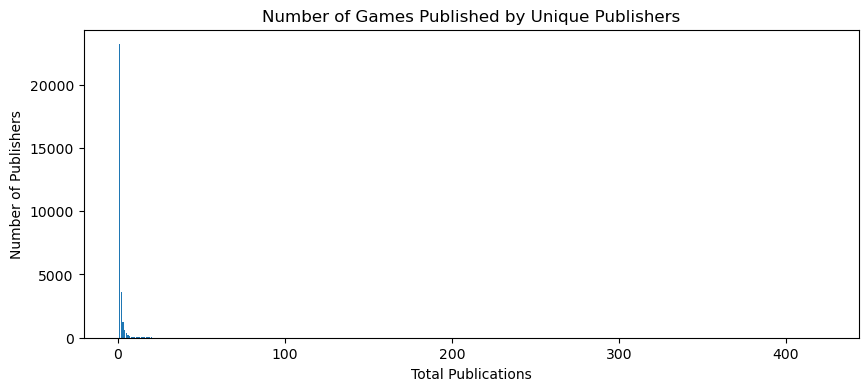

In [52]:
plt.figure(figsize=(10,4))
plt.bar(publication_df['Total Games Published'], publication_df['Number of Publishers'])
plt.title('Number of Games Published by Unique Publishers')
plt.xlabel('Total Publications')
plt.ylabel('Number of Publishers')
plt.show()

As we can see, the vast majority of publishers only ever publish a single game on Steam, while, at the top end, a publisher has published 422 games.  Moreover, adding an "unknown" publisher for the 145 missing values would make it the 5th biggest publisher on Steam.

In [53]:
steam_games_df['Developer'].isna().sum()

129

In [56]:
# attempt to find missing values for developers using Steam's API
print('Missing values before:', steam_games_df['Developer'].isna().sum())

for index, row in steam_games_df.loc[steam_games_df['Developer'].isna(), ['Developer', 'app_id']].iterrows():
    app_id = row['app_id']
    _, developer = get_app_pubs_devs(app_id)

    if developer and developer not in ([''], ['N/A'], [' '], ['NA'], ['n/a']):
        steam_games_df.at[index, 'Developer'] = developer[0]

    # pause
    time.sleep(0.5)

print('Missing values after:', steam_games_df['Developer'].isna().sum())

Missing values before: 129
Missing values after: 128


Again, this effort was mostly in vain, only adding 1 value to our dataset.

In [57]:
# compare publishers and games published
devs_per_games = steam_games_df['Developer'].value_counts().value_counts().sort_index()

developer_df = pd.DataFrame({
    'Number of Developers': devs_per_games.values,
    'Total Games Developed': devs_per_games.index
})

display(developer_df.head())
display(developer_df.tail())

,Number of Developers,Total Games Developed
0,27126,1
1,4197,2
2,1484,3
3,691,4
4,370,5


,Number of Developers,Total Games Developed
53,1,90
54,1,98
55,1,108
56,1,122
57,1,140


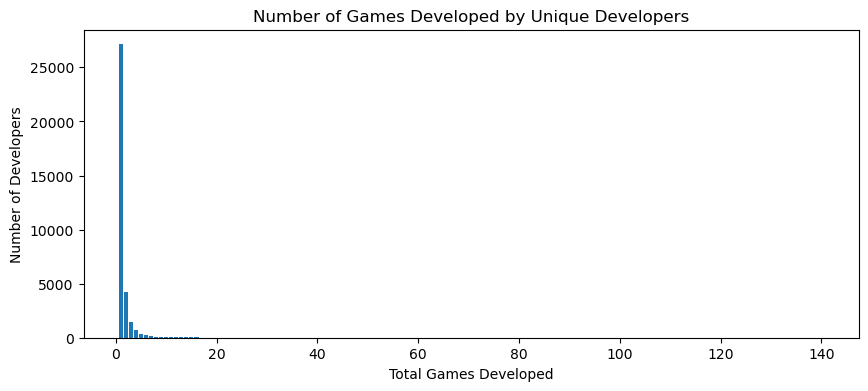

In [58]:
plt.figure(figsize=(10,4))
plt.bar(developer_df['Total Games Developed'], developer_df['Number of Developers'])
plt.title('Number of Games Developed by Unique Developers')
plt.xlabel('Total Games Developed')
plt.ylabel('Number of Developers')
plt.show()

Again, the vast majority of developers only ever develop a single game.  While it would be possible to do a one-hot encoding of these publishers and developers, the matrices would be extremely sparse, likely not giving any valuable information.  Instead, I will leave these as-is until the EDA notebook.  There, I will be able to look in further detail into whether certain publishers are frequently publishing the most popular games (as I expect), which cane be useful for understanding if a game will receive a positive (or negative) rating.

In [59]:
steam_games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55691 entries, 0 to 55690
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   app_id            55691 non-null  int64 
 1   Name              55691 non-null  object
 2   description       55654 non-null  object
 3   Developer         55563 non-null  object
 4   Publisher         55546 non-null  object
 5   Genre             55530 non-null  object
 6   Tags              55556 non-null  object
 7   Type              55691 non-null  object
 8   Categories        54721 non-null  object
 9   Owners            55691 non-null  object
 10  positive_reviews  55691 non-null  int64 
 11  negative_reviews  55691 non-null  int64 
 12  Price             55691 non-null  int64 
 13  Discount          55691 non-null  int64 
 14  CCU               55691 non-null  int64 
 15  Languages         55680 non-null  object
 16  Platforms         55691 non-null  object
 17  release_date

My earlier efforts to acquire missing data were not particularly successful.  In addition, we can see that several columns have null values. `Tags`, `Genre`, `Categories`, `Developer`, `Publisher`, and `Description` all have between 100 and 300 missing values.  Dropping them all, however, could result in several thousand rows being dropped if they are all mutually exclusive.  For that reason, I'll check to see if there is significant overlap in null values.   

In [60]:
columns_to_check = ['Genre', 'Developer', 'Publisher', 'Tags', 'Type', 'Categories', 'Languages', 'description']

# get the rows that have at least one null values in the columns_to_check
null_values = steam_games_df[columns_to_check].isna().any(axis=1)
total_null_rows = steam_games_df[null_values].shape[0]

print(f'The total number of rows with null values is \
{total_null_rows} which is {(total_null_rows / steam_games_df.shape[0])*100: 0.3f}% of the dataset')



The total number of rows with null values is 1425 which is  2.559% of the dataset


In [61]:
# look at the type column
steam_games_df['Type'].unique()

array(['game', 'hardware'], dtype=object)

In [62]:
# find out what the 'hardware' type means
steam_games_df.loc[steam_games_df['Type'] == 'hardware']

,app_id,Name,description,Developer,Publisher,Genre,Tags,Type,Categories,Owners,...,negative_reviews,Price,Discount,CCU,Languages,Platforms,release_date,required_age,Website,Header Image
32106,353380,Steam Link,Extend your Steam gaming experience to your mo...,NaN,Anima Locus,NaN,"Steam Machine: 440, Software: 39, Shooter: 23,...",hardware,"Full controller support, Remote Play Together","500,000 .. 1,000,000",...,1771,0,0,0,NaN,"windows, mac, linux",2015/11/10,0,https://store.steampowered.com/remoteplay,https://cdn.akamai.steamstatic.com/steam/apps/...


The `game_reviews_df` has almost all the same data as my `steam_games_df`.  Differences include the `Owners`, `Publisher`, `Developer`, `CCU`, and `Languages` columns.  These columns, however, will add a significant amount of effort to clean while I am not sure they will be used for modelling.  For now, I will not continue to clean this dataset, although it will still be useful for displaying recommendations in the UI.

## <a id='toc1_3_'></a>[Data Output and Data Dictionaries](#toc0_)

The cleaned datasets will be output into the following files:
- clean_game_data.csv
- clean_user_data.csv
- clean_recommendations.csv

In [63]:
game_reviews_df.to_csv('data/clean_game_data.csv', index=False)
users_df.to_csv('data/clean_user_data.csv', index=False)
recommendations_df.to_csv('data/clean_recommendations.csv', index=False)